In [9]:
import sys
sys.path.append('/home/mmann1123/Documents/github/xr_fresh/')
import numpy as np
import dask.array as da
import xarray as xr
from xr_fresh.backends import Cluster
from xr_fresh.extractors import extract_features
from xr_fresh.transformers import Stackerizer 

from sklearn_xarray import wrap, Target
from sklearn_xarray.preprocessing import Splitter, Sanitizer, Featurizer
from sklearn_xarray.model_selection import CrossValidatorWrapper
from sklearn_xarray.datasets import load_wisdm_dataarray
from sklearn.preprocessing import StandardScaler, LabelEncoder,LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline


nrows = 100
ncols = 200
row_chunks = 50
col_chunks = 50

data = da.random.random(size=(1, nrows, ncols), chunks=(1, row_chunks, col_chunks))

def create_band(data, x, y, band_name):

    return xr.DataArray(data,
                        dims=('band', 'y', 'x'),
                        coords={'band': [band_name],
                                'y': y,
                                'x': x})

def create_coords(data, left, top, celly, cellx):
    nrows = data.shape[-2]
    ncols = data.shape[-1]
    right = left + cellx*ncols
    bottom = top - celly*nrows
    x = np.linspace(left, right, ncols) + cellx/2.0
    y = np.linspace(top, bottom, nrows) - celly/2.0
    
    return x, y

x, y = create_coords(data, 1000, 2000, 30, 30)

src = []

for time in ['t1', 't2', 't3']:

    src_t = xr.concat([create_band(data, x, y, band) for band in ['blue', 'green', 'red', 'nir']], dim='band')\
                    .expand_dims(dim='time')\
                    .assign_coords({'time': [time]})
    
    src.append(src_t)

src = xr.concat(src, dim='time')
src = src.chunk((len(src.time), 1, 350, 350))
src.attrs['nodatavals'] =  (-9999,)
print(src)

<xarray.DataArray 'random_sample-978a316c543ecafdfa40baca61f553e3' (time: 3, band: 4, y: 100, x: 200)>
dask.array<rechunk-merge, shape=(3, 4, 100, 200), dtype=float64, chunksize=(3, 1, 100, 200), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 1.985e+03 1.955e+03 1.924e+03 ... -984.7 -1.015e+03
  * x        (x) float64 1.015e+03 1.045e+03 1.075e+03 ... 6.985e+03 7.015e+03
  * band     (band) object 'blue' 'green' 'red' 'nir'
  * time     (time) object 't1' 't2' 't3'
Attributes:
    nodatavals:  (-9999,)


### Create time series features

In [10]:
%%time
complete_f =  {
                'abs_energy':[{}],       
                'mean_abs_change':[{}],  
                'variance_larger_than_standard_deviation':[{}],   
                'ratio_beyond_r_sigma':[{'r':1},{'r':2},{'r':3}],
                'large_standard_deviation':[{'r':0.5},{'r':1},{'r':2},{'r':3}],
                 'symmetry_looking':[{}],
                 'sum_values':[{}],
                 'autocorr':[{'lag':1},{'lag':2}],   
                 'ts_complexity_cid_ce':[{}],
                 'mean_change':[{}],  
                 'maximum':[{}],  
                 'median':[{}],
                 'minimum':[{}],
                }


# start cluster
cluster = Cluster()
cluster.start_large_object()

features = extract_features(xr_data= src,
                                feature_dict=complete_f,
                                band='blue', 
                                na_rm = True)
    
 
cluster.close()

<Client: 'inproc://192.168.86.103/229385/10' processes=1 threads=12, memory=67.08 GB>
go to http://localhost:8787/status for dask dashboard
Extracting:  abs_energy
Extracting:  mean_abs_change
Extracting:  variance_larger_than_standard_deviation
Extracting:  ratio_beyond_r_sigma
Extracting:  ratio_beyond_r_sigma
Extracting:  ratio_beyond_r_sigma
Extracting:  large_standard_deviation
Extracting:  large_standard_deviation
Extracting:  large_standard_deviation
Extracting:  large_standard_deviation
Extracting:  symmetry_looking
Extracting:  sum_values
Extracting:  autocorr
Extracting:  autocorr
Extracting:  ts_complexity_cid_ce
Extracting:  mean_change
Extracting:  maximum
Extracting:  median
Extracting:  minimum
CPU times: user 952 ms, sys: 66.7 ms, total: 1.02 s
Wall time: 2.54 s


In [11]:
features.shape
features

<xarray.DataArray 'random_sample-978a316c543ecafdfa40baca61f553e3' (variable: 19, y: 100, x: 200)>
array([[[8.70347825e-01, 9.00445121e-01, 2.69386445e+00, ...,
         2.78970771e-01, 6.34578109e-01, 4.21625112e-04],
        [2.76156856e-01, 4.18844953e-02, 2.61940945e-01, ...,
         1.41221311e-03, 2.47803888e+00, 1.08739184e+00],
        [7.75123366e-03, 7.36112673e-01, 1.31022748e+00, ...,
         1.94023818e-01, 6.98716596e-02, 8.47217997e-01],
        ...,
        [1.23495166e-04, 5.30533732e-01, 1.56371651e+00, ...,
         1.04997399e-02, 2.42301862e-01, 1.09220745e+00],
        [4.62428113e-02, 2.05696697e+00, 2.54810472e+00, ...,
         8.14869812e-02, 1.43239191e+00, 1.58786549e+00],
        [2.91591601e+00, 1.07401676e+00, 6.15914536e-01, ...,
         1.15928187e+00, 1.57531998e+00, 1.65495367e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [6.41599995e-03, 4.20528926e-01, 7.21968723e-01, ...,
         5.91600650e-02, 2.84195861e-01, 6.03381429e-01],
        [1.24154220e-01, 8.28043269e-01, 9.21611762e-01, ...,
         1.64809973e-01, 6.90987677e-01, 7.27522163e-01],
        [9.85886405e-01, 5.98335682e-01, 4.53105777e-01, ...,
         6.21632762e-01, 7.24642437e-01, 7.42732269e-01]],

       [[5.38624119e-01, 5.47857987e-01, 9.47604779e-01, ...,
         3.04943039e-01, 4.59919598e-01, 1.18550286e-02],
        [3.03401195e-01, 1.18158785e-01, 2.95488829e-01, ...,
         2.16964905e-02, 9.08852551e-01, 6.02049787e-01],
        [5.08305474e-02, 4.95349262e-01, 6.60864957e-01, ...,
         2.54312025e-01, 1.52612428e-01, 5.31418855e-01],
        ...,
        [6.41599995e-03, 4.20528926e-01, 7.21968723e-01, ...,
         5.91600650e-02, 2.84195861e-01, 6.03381429e-01],
        [1.24154220e-01, 8.28043269e-01, 9.21611762e-01, ...,
         1.64809973e-01, 6.90987677e-01, 7.27522163e-01],
        [9.85886405e-01, 5.98335682e-01, 4.53105777e-01, ...,
         6.21632762e-01, 7.24642437e-01, 7.42732269e-01]]])
Coordinates:
    band      <U4 'blue'
  * x         (x) float64 1.015e+03 1.045e+03 1.075e+03 ... 6.985e+03 7.015e+03
  * y         (y) float64 1.985e+03 1.955e+03 1.924e+03 ... -984.7 -1.015e+03
  * variable  (variable) object 'blue__abs_energy_' ... 'blue__minimum_'

### Add target value 

In [12]:
land_use = np.tile( "water", ( src.sizes["y"], src.sizes["x"]) ).astype(object)
land_use[features.sel(variable='blue__abs_energy_').values > 0.5] = "forest"
land_use = land_use.astype(str)
features.coords["land_use"] = (["y", "x"], land_use)
features

<xarray.DataArray 'random_sample-978a316c543ecafdfa40baca61f553e3' (variable: 19, y: 100, x: 200)>
array([[[8.70347825e-01, 9.00445121e-01, 2.69386445e+00, ...,
         2.78970771e-01, 6.34578109e-01, 4.21625112e-04],
        [2.76156856e-01, 4.18844953e-02, 2.61940945e-01, ...,
         1.41221311e-03, 2.47803888e+00, 1.08739184e+00],
        [7.75123366e-03, 7.36112673e-01, 1.31022748e+00, ...,
         1.94023818e-01, 6.98716596e-02, 8.47217997e-01],
        ...,
        [1.23495166e-04, 5.30533732e-01, 1.56371651e+00, ...,
         1.04997399e-02, 2.42301862e-01, 1.09220745e+00],
        [4.62428113e-02, 2.05696697e+00, 2.54810472e+00, ...,
         8.14869812e-02, 1.43239191e+00, 1.58786549e+00],
        [2.91591601e+00, 1.07401676e+00, 6.15914536e-01, ...,
         1.15928187e+00, 1.57531998e+00, 1.65495367e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [6.41599995e-03, 4.20528926e-01, 7.21968723e-01, ...,
         5.91600650e-02, 2.84195861e-01, 6.03381429e-01],
        [1.24154220e-01, 8.28043269e-01, 9.21611762e-01, ...,
         1.64809973e-01, 6.90987677e-01, 7.27522163e-01],
        [9.85886405e-01, 5.98335682e-01, 4.53105777e-01, ...,
         6.21632762e-01, 7.24642437e-01, 7.42732269e-01]],

       [[5.38624119e-01, 5.47857987e-01, 9.47604779e-01, ...,
         3.04943039e-01, 4.59919598e-01, 1.18550286e-02],
        [3.03401195e-01, 1.18158785e-01, 2.95488829e-01, ...,
         2.16964905e-02, 9.08852551e-01, 6.02049787e-01],
        [5.08305474e-02, 4.95349262e-01, 6.60864957e-01, ...,
         2.54312025e-01, 1.52612428e-01, 5.31418855e-01],
        ...,
        [6.41599995e-03, 4.20528926e-01, 7.21968723e-01, ...,
         5.91600650e-02, 2.84195861e-01, 6.03381429e-01],
        [1.24154220e-01, 8.28043269e-01, 9.21611762e-01, ...,
         1.64809973e-01, 6.90987677e-01, 7.27522163e-01],
        [9.85886405e-01, 5.98335682e-01, 4.53105777e-01, ...,
         6.21632762e-01, 7.24642437e-01, 7.42732269e-01]]])
Coordinates:
    band      <U4 'blue'
  * x         (x) float64 1.015e+03 1.045e+03 1.075e+03 ... 6.985e+03 7.015e+03
  * y         (y) float64 1.985e+03 1.955e+03 1.924e+03 ... -984.7 -1.015e+03
  * variable  (variable) object 'blue__abs_energy_' ... 'blue__minimum_'
    land_use  (y, x) <U6 'forest' 'forest' 'forest' ... 'forest' 'forest'

### Vectorize for sklean

In [13]:
X = Stackerizer(stack_dims = ('x','y'), direction='stack').fit_transform(features)
print(X)

<xarray.DataArray 'random_sample-978a316c543ecafdfa40baca61f553e3' (sample: 20000, variable: 19)>
array([[0.87034783, 0.        , 0.        , ..., 0.53862412, 0.53862412,
        0.53862412],
       [0.27615686, 0.        , 0.        , ..., 0.3034012 , 0.3034012 ,
        0.3034012 ],
       [0.00775123, 0.        , 0.        , ..., 0.05083055, 0.05083055,
        0.05083055],
       ...,
       [1.09220745, 0.        , 0.        , ..., 0.60338143, 0.60338143,
        0.60338143],
       [1.58786549, 0.        , 0.        , ..., 0.72752216, 0.72752216,
        0.72752216],
       [1.65495367, 0.        , 0.        , ..., 0.74273227, 0.74273227,
        0.74273227]])
Coordinates:
    band      <U4 'blue'
  * variable  (variable) object 'blue__abs_energy_' ... 'blue__minimum_'
    land_use  (sample) <U6 'forest' 'water' 'water' ... 'forest' 'forest'
  * sample    (sample) MultiIndex
  - x         (sample) float64 1.015e+03 1.015e+03 ... 7.015e+03 7.015e+03
  - y         (sample) float64 

### Set up ML pipeline 

In [14]:
pl = Pipeline(
    [  
#        ("stackerizer", Stackerizer(stack_dims=["x", "y", "time"])),
       ("sanitizer", Sanitizer(dim='variable')),    # Remove elements containing NaNs.
       ("featurizer", Featurizer()),  # Stack all dimensions and variables except for sample dimension.
       ("scaler", wrap(StandardScaler)), # zscores , ?wrap if xarray.self required? 
       ("pca", wrap(PCA, reshapes="feature")), 
       ("cls", wrap(GaussianNB, reshapes="feature")),
    ]
)

# pl = Pipeline(     For future version of sklearn-xarray
#     [
#         ("stacker", Stacker(stack_dims=["x", "y", "time"])),
#         ("transposer", Transposer(order=("sample", "band"))),
#         ("scaler", wrap(StandardScaler)),
#         ("pca", wrap(PCA, reshapes="feature")),
#         ("cls", wrap(GaussianNB, reshapes="feature")),
#     ]
# )

##############################################################################
# Since we want to use cross-validated grid search to find the best model
# parameters, we define a cross-validator. In order to make sure the model
# performs subject-independent recognition, we use a `GroupShuffleSplit`
# cross-validator that ensures that the same subject will not appear in both
# training and validation set.

cv = CrossValidatorWrapper(
    GroupShuffleSplit(n_splits=3, test_size=0.5), groupby=["x",'y']
)

##############################################################################
# The grid search will try different numbers of PCA components to find the best
# parameters for this task.

gs = GridSearchCV(
    pl, cv=cv, n_jobs=-1, verbose=1, param_grid={"pca__n_components": [5,10]}
)

##############################################################################
# The label to classify is the activity which we convert to an integer
# representation for the classification.

y = Target(
    coord="land_use", transform_func=LabelEncoder().fit_transform )(X)

# y = Target(    For future version of sklearn-xarray
#     coord="land_use",
#     transform_func=LabelBinarizer().fit_transform,
#     dim="sample",
# )
##############################################################################
# Finally, we run the grid search and print out the best parameter combination.

gs.fit(X, y)
print("Best parameters: {0}".format(gs.best_params_))
print("Accuracy: {0}".format(gs.best_score_))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.2s finished
Best parameters: {'pca__n_components': 5}
Accuracy: 0.9525


### Predict back to stack


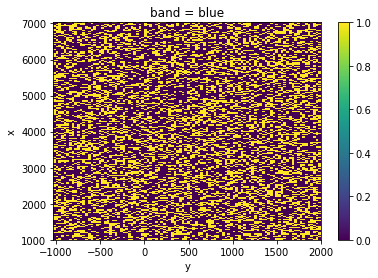

In [15]:
yp = gs.predict(X)
yp = yp.unstack("sample")
yp.plot.imshow()

In [8]:
# predict labels
yp = gs.predict(X)
yp.values = LabelEncoder().fit(X.land_use).classes_[yp]
yp = yp.unstack("sample")
print(yp)

<xarray.DataArray (x: 200, y: 100)>
array([['water', 'forest', 'forest', ..., 'water', 'forest', 'water'],
       ['forest', 'water', 'water', ..., 'forest', 'water', 'forest'],
       ['forest', 'forest', 'forest', ..., 'forest', 'forest', 'forest'],
       ...,
       ['forest', 'forest', 'forest', ..., 'water', 'forest', 'water'],
       ['forest', 'forest', 'forest', ..., 'forest', 'forest', 'forest'],
       ['forest', 'forest', 'water', ..., 'forest', 'forest', 'water']],
      dtype='<U6')
Coordinates:
    band      <U4 'blue'
    land_use  (x, y) <U6 'water' 'forest' 'forest' ... 'forest' 'forest' 'water'
  * x         (x) float64 1.015e+03 1.045e+03 1.075e+03 ... 6.985e+03 7.015e+03
  * y         (y) float64 1.985e+03 1.955e+03 1.924e+03 ... -984.7 -1.015e+03
